# EDA - Datos socio demográficos y de recursos de salud a nivel de condado de EE. UU. (2018-2019)

In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from pickle import dump
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# 1. Problem statement and data collection

In [4]:
total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv")
total_data.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,...,Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,13.636445,7738,13.917016,5826,10.478229,4050,7.284042,2014,3.622237,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,158,455,11.8,9.6,2.2,0.0,0.7,...,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,Autauga,Alabama,1,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,12.539102,29986,13.753658,29932,13.728890,20936,9.602701,9368,4.296814,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,5403,2190,10.5,10.3,0.1,0.5,24.3,...,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,Baldwin,Alabama,1,3,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,12.354809,3278,13.174712,3076,12.362847,2244,9.018930,1048,4.212049,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,0.184880,307,1.233873,24881,-277,2820,10.4,12.9,-2.5,0.5,-9.1,...,12.914231,2.723340,0.514126,11.631462,9.508784,32.283033,5,26201,6150,23.5,Barbour,Alabama,1,5,19689,57.5,55.6,59.1,11325,40.7,39.5,41.9,8013,11.0,10.1,11.8,2159,12.1,10.7,13.3,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,3038,13.562500,3115,13.906250,2545,11.361607,1723,7.691964,785,3.504464,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,0.116071,242,1.080357,22400,-155,2151,11.1,11.4,-0.3,0.4,-7.0,...,11.626493,2.451783,0.462860,10.471635,8.560619,29.063942,0,22580,4773,21.1,Bibb,Alabama,1,7,17813,51.6,49.6,53.4,9190,38.7,37.4,40.2,6894,8.6,7.9,9.3,1533,10.0,8.8,11.3,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,7474,12.921853,7844,13.561549,6965,12.041840,4931,8.525242,2335,4.036999,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,0.121024,801,1.384855,57840,13,489,11.8,11.4,0.3,0.1,-0.2,...,30.021267,6.330854,1.195171,27.039257,22.104740,75.047251,6,57667,13600,23.6,Blount,Alabama,1,9,44448,46.3,44.3,48.4,20584,34.0,32.4,35.5,15112,9.2,8.4,10.1,4101,10.5,9.1,12.0,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


# 2. Exploration and data cleaning
# 2.1 Understanding the features:

In [5]:
# Obtener las dimensiones
print('Our dataframe contains {} rows, indicating the total number of rentals, and has a shape of {}.'.format(len(total_data), total_data.shape))

Our dataframe contains 3140 rows, indicating the total number of rentals, and has a shape of (3140, 108).


In [6]:
# Obtener información sobre tipos de datos y valores no nulos
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


# 2.2 Identifying Null Values and data types for each feature

In [7]:
total_data.isna().sum()[total_data.isna().sum()>0]

Series([], dtype: int64)

# 2.3 Looking for duplicated and dropping them, if any.

In [8]:
#Eliminamos los duplicados
total_data = total_data.drop_duplicates().reset_index(drop = True)
total_data.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,...,Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,13.636445,7738,13.917016,5826,10.478229,4050,7.284042,2014,3.622237,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,158,455,11.8,9.6,2.2,0.0,0.7,...,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,Autauga,Alabama,1,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,12.539102,29986,13.753658,29932,13.728890,20936,9.602701,9368,4.296814,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,5403,2190,10.5,10.3,0.1,0.5,24.3,...,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,Baldwin,Alabama,1,3,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,12.354809,3278,13.174712,3076,12.362847,2244,9.018930,1048,4.212049,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,0.184880,307,1.233873,24881,-277,2820,10.4,12.9,-2.5,0.5,-9.1,...,12.914231,2.723340,0.514126,11.631462,9.508784,32.283033,5,26201,6150,23.5,Barbour,Alabama,1,5,19689,57.5,55.6,59.1,11325,40.7,39.5,41.9,8013,11.0,10.1,11.8,2159,12.1,10.7,13.3,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,3038,13.562500,3115,13.906250,2545,11.361607,1723,7.691964,785,3.504464,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,0.116071,242,1.080357,22400,-155,2151,11.1,11.4,-0.3,0.4,-7.0,...,11.626493,2.451783,0.462860,10.471635,8.560619,29.063942,0,22580,4773,21.1,Bibb,Alabama,1,7,17813,51.6,49.6,53.4,9190,38.7,37.4,40.2,6894,8.6,7.9,9.3,1533,10.0,8.8,11.3,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,7474,12.921853,7844,13.561549,6965,12.041840,4931,8.525242,2335,4.036999,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,0.121024,801,1.384855,57840,13,489,11.8,11.4,0.3,0.1,-0.2,...,30.021267,6.330854,1.195171,27.039257,22.104740,75.047251,6,57667,13600,23.6,Blount,Alabama,1,9,44448,46.3,44.3,48.4,20584,34.0,32.4,35.5,15112,9.2,8.4,10.1,4101,10.5,9.1,12.0,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


# 2.4 Dealing with null values

In [9]:
#Sacamos el porcentaje de valores NaN
total_data.isnull().sum().sort_values(ascending=False) / len(total_data)

fips                      0.0
TOT_POP                   0.0
0-9                       0.0
0-9 y/o % of total pop    0.0
19-Oct                    0.0
                         ... 
CKD_prevalence            0.0
CKD_Lower 95% CI          0.0
CKD_Upper 95% CI          0.0
CKD_number                0.0
Urban_rural_code          0.0
Length: 108, dtype: float64

# 3. Univariate Analysis
# 3.1 Dividing our dataset into categorial and numerical.

In [10]:
#Analizamos los tipos de información que tenemos
total_data.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [11]:
#Dividimos el dataframe original por valores numéricos y categóricos
num = ['int64', 'float64']
cat = ['O']

df_num = total_data.select_dtypes(num)
df_cat = total_data.select_dtypes(cat)

In [12]:
df_cat.head(3)

,COUNTY_NAME,STATE_NAME
0,Autauga,Alabama
1,Baldwin,Alabama
2,Barbour,Alabama


# 3.2 Categorical Variable Analysis

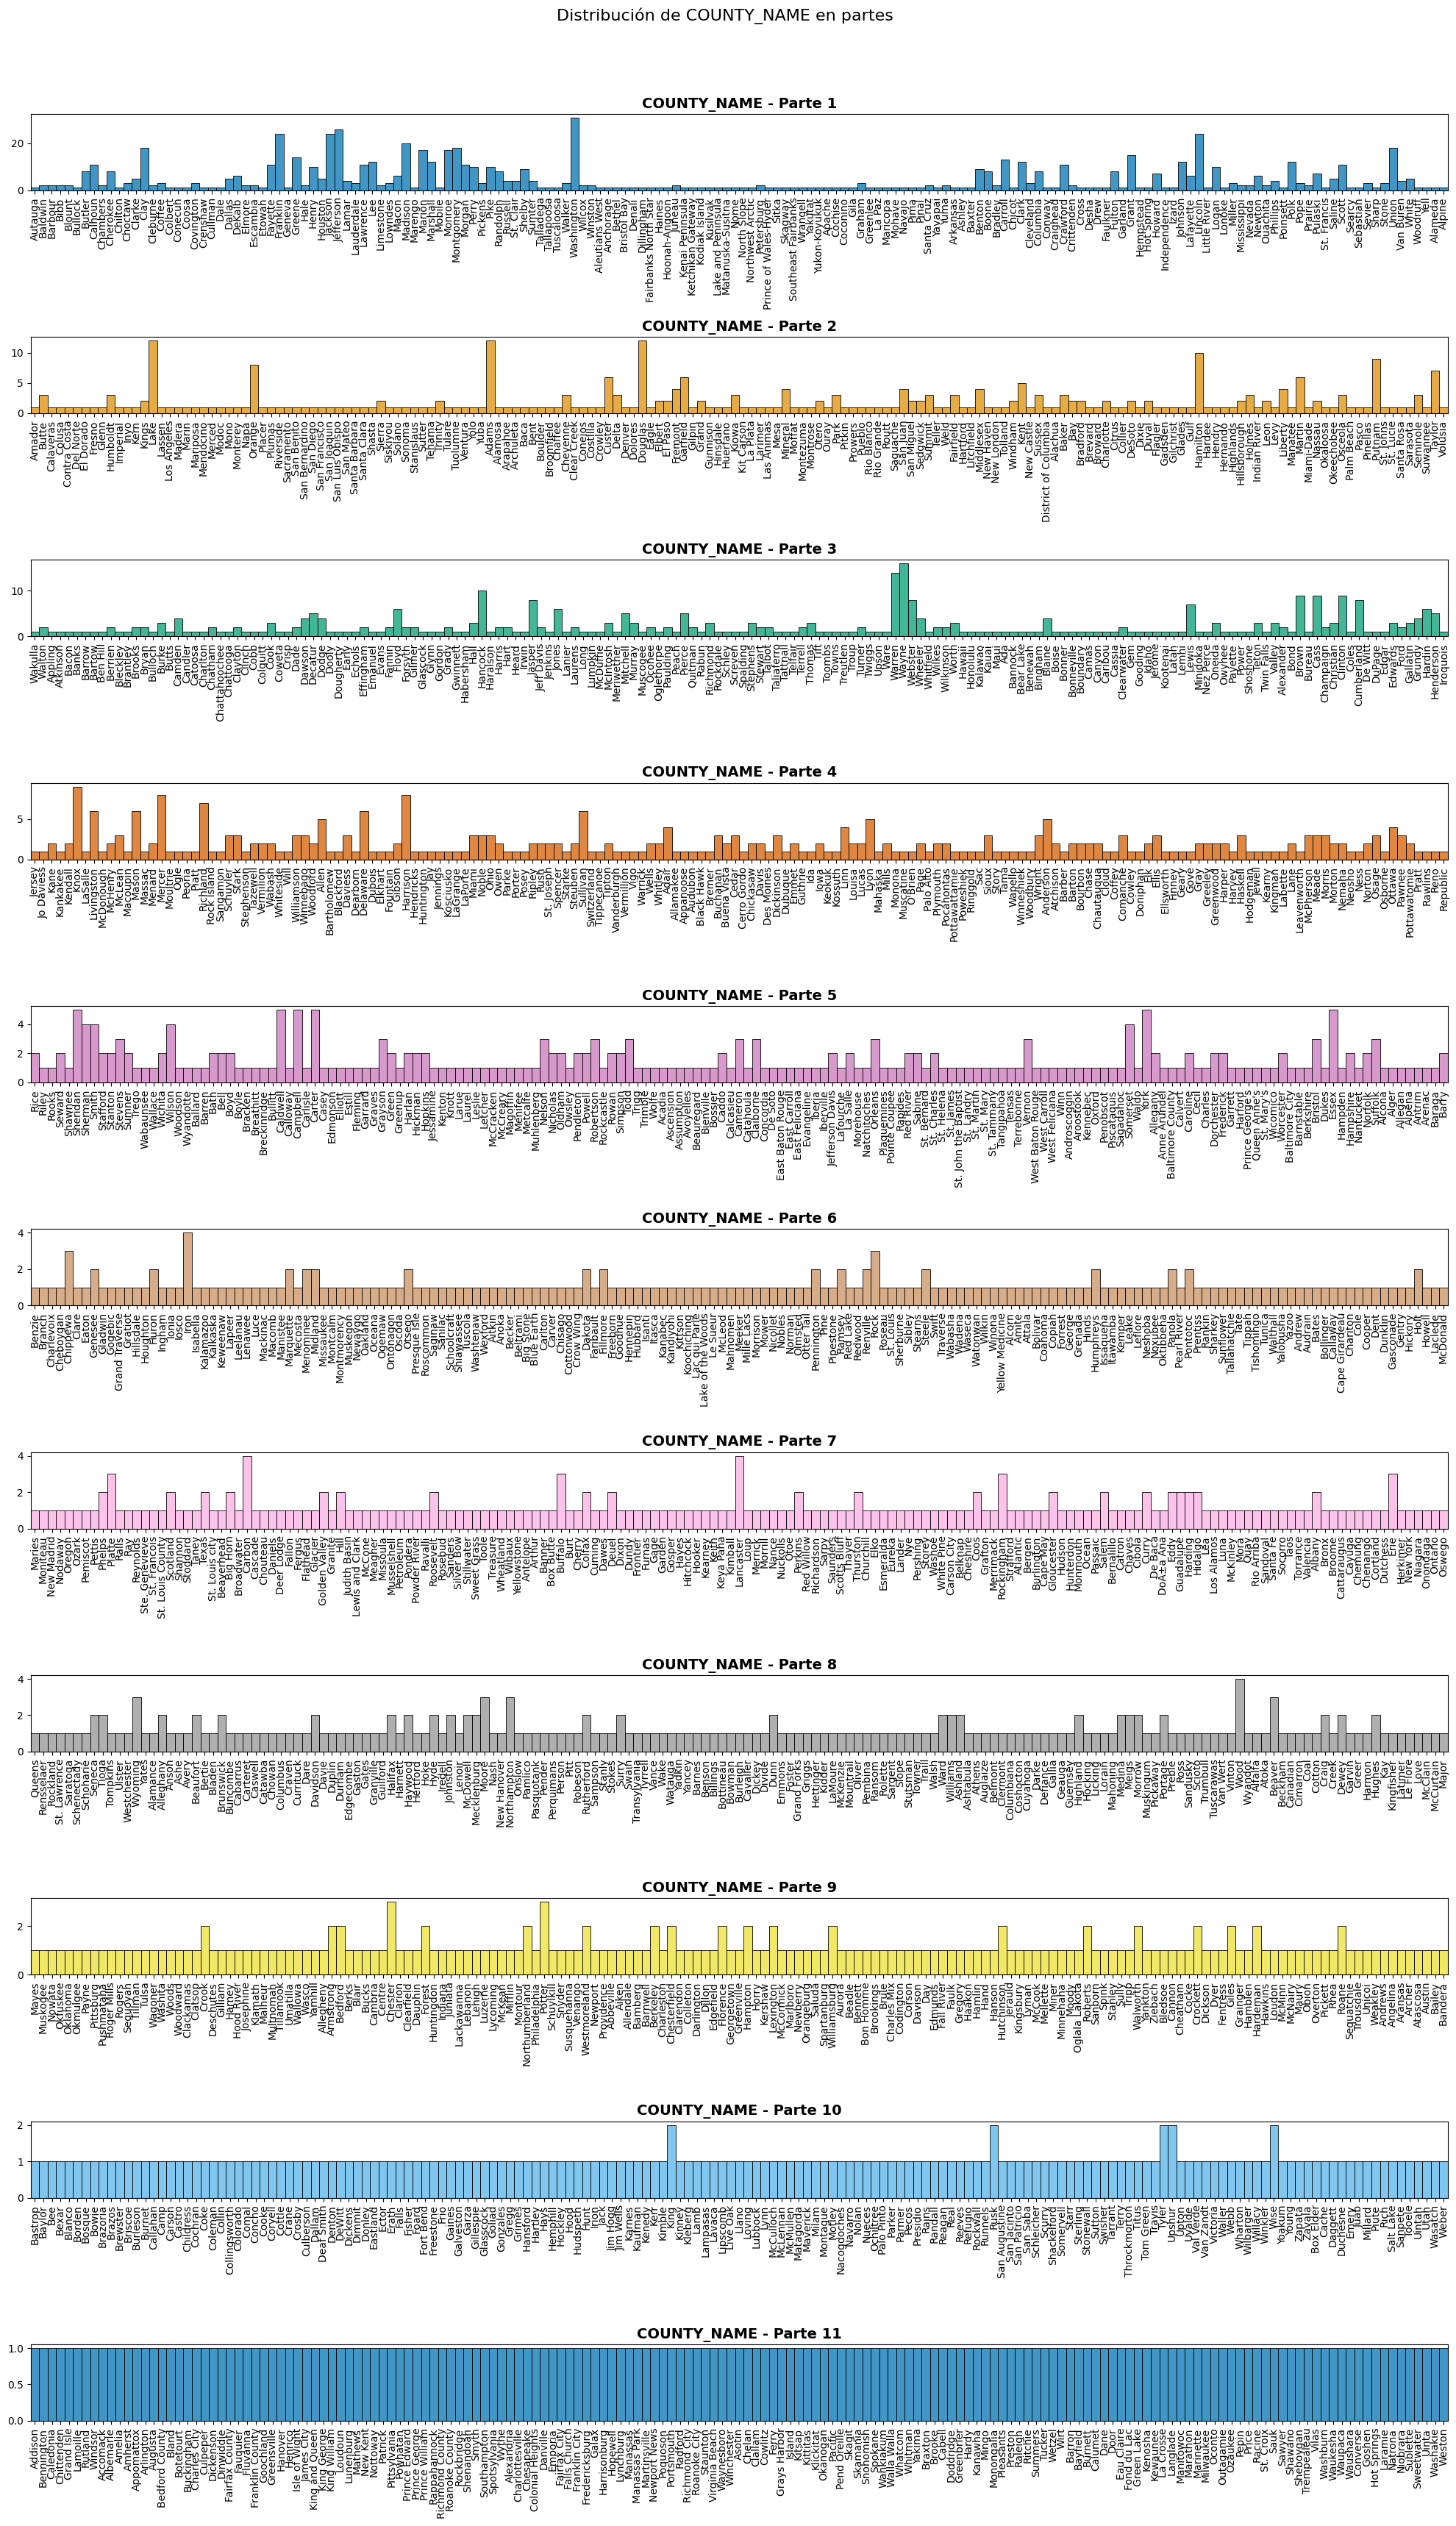

In [13]:
county_names = df_cat['COUNTY_NAME'].unique()
num_particiones = 11
divisiones = np.array_split(county_names, num_particiones)

fig, axis = plt.subplots(num_particiones, 1, figsize=(20, 35))
fig.suptitle("Distribución de COUNTY_NAME en partes", fontsize=16)

colores = sns.color_palette("colorblind", num_particiones)

for i, division in enumerate(divisiones):
    subset = df_cat[df_cat['COUNTY_NAME'].isin(division)]
    ax = axis[i]
    sns.histplot(data=subset, x="COUNTY_NAME", ax=ax, color=colores[i]).set(xlabel=None, ylabel=None)
    ax.set_title(f"COUNTY_NAME - Parte {i+1}", fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=90)
    ax.margins(x=0)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

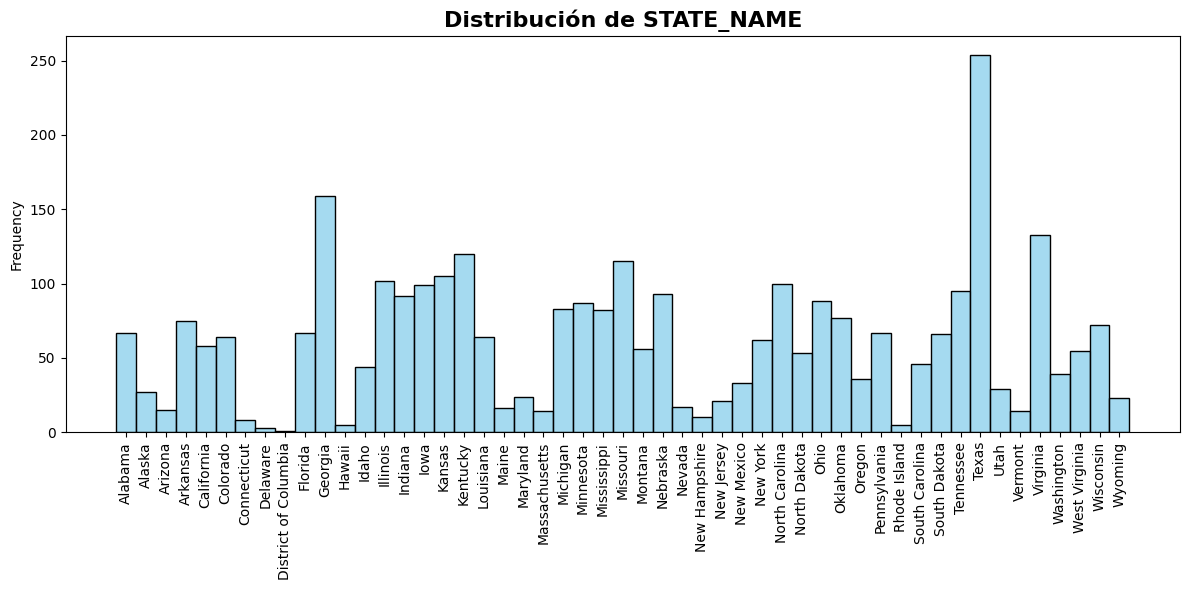

In [14]:
plt.figure(figsize=(12, 6))

sns.histplot(data=df_cat, x="STATE_NAME", color="skyblue").set(xlabel=None, ylabel="Frequency")
plt.title("Distribución de STATE_NAME", fontsize=16, fontweight='bold')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# 3.3 Numerical Variable Analysis

In [15]:
df_num.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,...,Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,13.636445,7738,13.917016,5826,10.478229,4050,7.284042,2014,3.622237,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,158,455,11.8,9.6,2.2,0.0,0.7,...,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,1,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,12.539102,29986,13.753658,29932,13.728890,20936,9.602701,9368,4.296814,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,5403,2190,10.5,10.3,0.1,0.5,24.3,...,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,1,3,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,12.354809,3278,13.174712,3076,12.362847,2244,9.018930,1048,4.212049,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,0.184880,307,1.233873,24881,-277,2820,10.4,12.9,-2.5,0.5,-9.1,...,7.6,6.9,12.914231,2.723340,0.514126,11.631462,9.508784,32.283033,5,26201,6150,23.5,1,5,19689,57.5,55.6,59.1,11325,40.7,39.5,41.9,8013,11.0,10.1,11.8,2159,12.1,10.7,13.3,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,3038,13.562500,3115,13.906250,2545,11.361607,1723,7.691964,785,3.504464,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,0.116071,242,1.080357,22400,-155,2151,11.1,11.4,-0.3,0.4,-7.0,...,7.6,6.9,11.626493,2.451783,0.462860,10.471635,8.560619,29.063942,0,22580,4773,21.1,1,7,17813,51.6,49.6,53.4,9190,38.7,37.4,40.2,6894,8.6,7.9,9.3,1533,10.0,8.8,11.3,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,7474,12.921853,7844,13.561549,6965,12.041840,4931,8.525242,2335,4.036999,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,0.121024,801,1.384855,57840,13,489,11.8,11.4,0.3,0.1,-0.2,...,7.6,6.9,30.021267,6.330854,1.195171,27.039257,22.104740,75.047251,6,57667,13600,23.6,1,9,44448,46.3,44.3,48.4,20584,34.0,32.4,35.5,15112,9.2,8.4,1

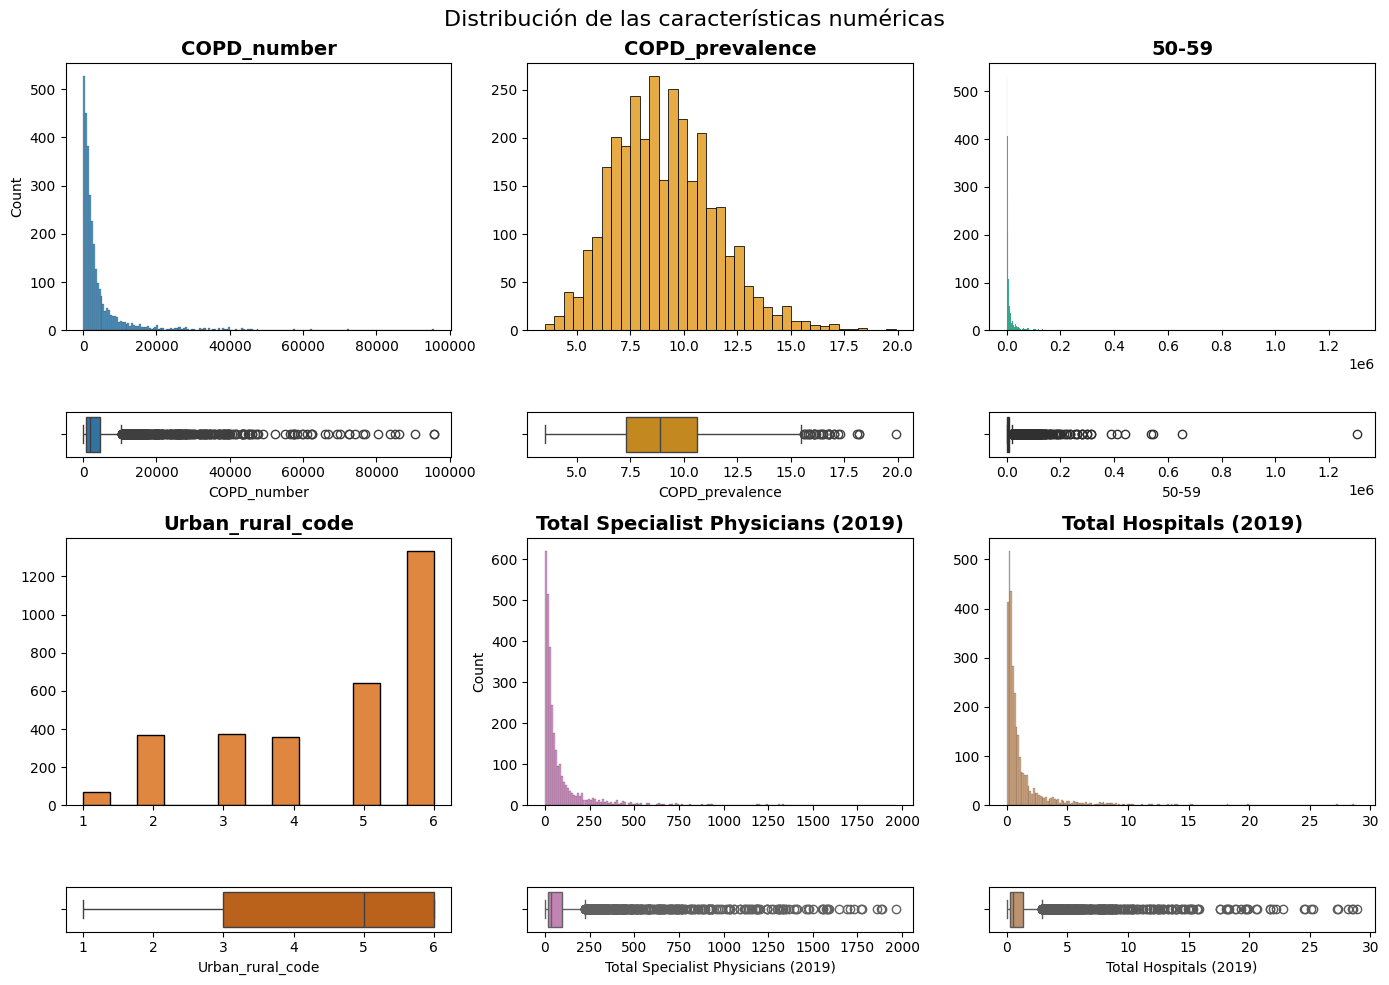

In [16]:
#Analisis con histogramas y boxplot de las características numéricas
fig, axis = plt.subplots(4, 3, figsize = (14, 10), gridspec_kw = {"height_ratios": [6, 1, 6, 1]})
fig.suptitle("Distribución de las características numéricas", fontsize=16)

sns.histplot(ax = axis[0, 0], data = df_num[df_num["COPD_number"] < 100000], x = "COPD_number").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = df_num[df_num["COPD_number"] < 100000], x = "COPD_number")

sns.histplot(ax = axis[0, 1], data = df_num, x = "COPD_prevalence", color=sns.color_palette("colorblind")[1]).set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = df_num, x = "COPD_prevalence", color=sns.color_palette("colorblind")[1])

sns.histplot(ax = axis[0, 2], data = df_num, x = "50-59", color=sns.color_palette("colorblind")[2]).set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 2], data = df_num, x = "50-59", color=sns.color_palette("colorblind")[2])

sns.histplot(ax = axis[2, 0], data = df_num, x = "Urban_rural_code", color=sns.color_palette("colorblind")[3]).set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 0], data = df_num, x = "Urban_rural_code", color=sns.color_palette("colorblind")[3])

sns.histplot(ax = axis[2, 1], data = df_num[df_num["Total Specialist Physicians (2019)"] < 2000], x = "Total Specialist Physicians (2019)", color=sns.color_palette("colorblind")[4]).set(xlabel = None)
sns.boxplot(ax = axis[3, 1], data = df_num[df_num["Total Specialist Physicians (2019)"] < 2000], x = "Total Specialist Physicians (2019)", color=sns.color_palette("colorblind")[4])

sns.histplot(ax = axis[2, 2], data = df_num[df_num["Total Hospitals (2019)"] < 30], x = "Total Hospitals (2019)", color=sns.color_palette("colorblind")[5]).set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 2], data = df_num[df_num["Total Hospitals (2019)"] < 30], x = "Total Hospitals (2019)", color=sns.color_palette("colorblind")[5])

axis[0, 0].set_title("COPD_number", fontsize=14, fontweight='bold')
axis[0, 1].set_title("COPD_prevalence", fontsize=14, fontweight='bold')
axis[0, 2].set_title("50-59", fontsize=14, fontweight='bold')
axis[2, 0].set_title("Urban_rural_code", fontsize=14, fontweight='bold')
axis[2, 1].set_title("Total Specialist Physicians (2019)", fontsize=14, fontweight='bold')
axis[2, 2].set_title("Total Hospitals (2019)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 4. Multivariate Analysis

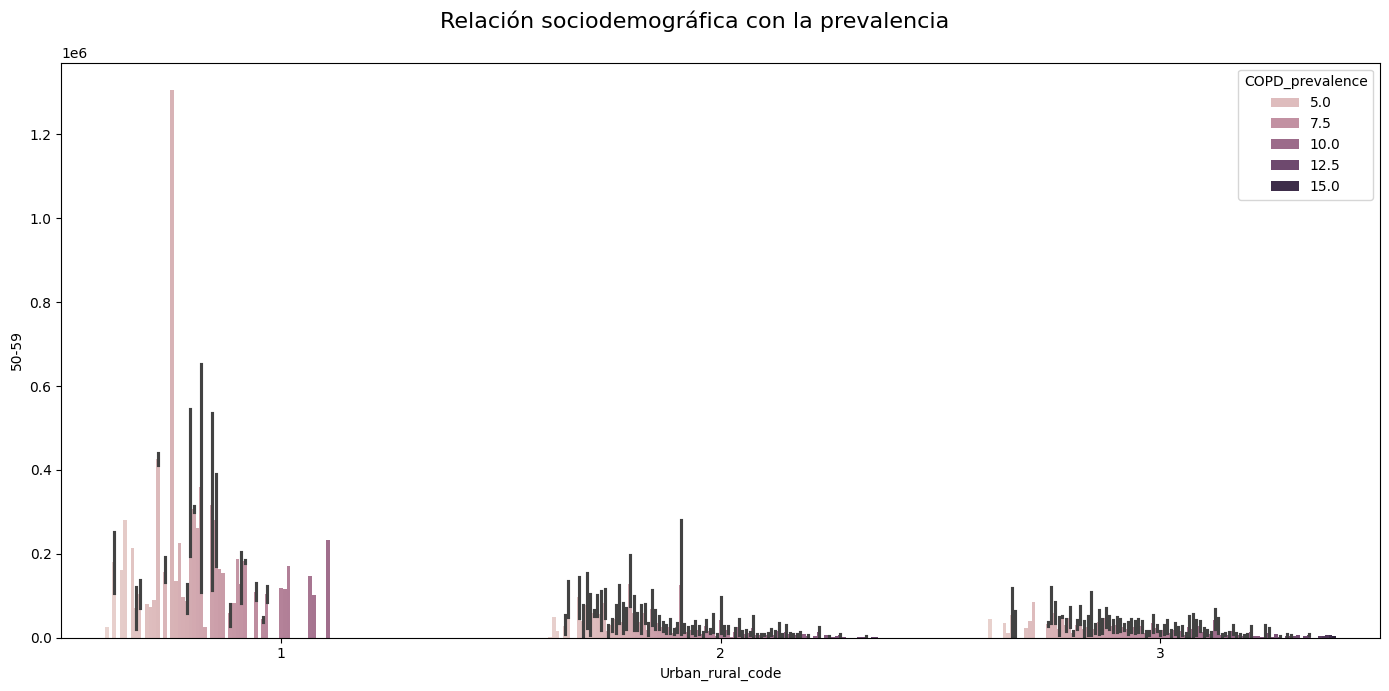

In [17]:
#Análisis combinando varias variables
fig, axis = plt.subplots(figsize = (14, 7))
fig.suptitle("Relación sociodemográfica con la prevalencia", fontsize=16)

sns.barplot(data = df_num[df_num["Urban_rural_code"] < 4], x = "Urban_rural_code", y = "50-59", hue = "COPD_prevalence")

plt.tight_layout()
plt.show()


Conclusiones:

- El gráfico sugiere que la prevalencia de EPOC está más concentrada en áreas urbanas, afectando principalmente a la población en edades entre 50 y 59 años.
- Las áreas menos urbanizadas muestran una menor prevalencia, lo que podría estar relacionado con diferencias en el **estilo de vida, exposición ambiental, y acceso a servicios de salud**.

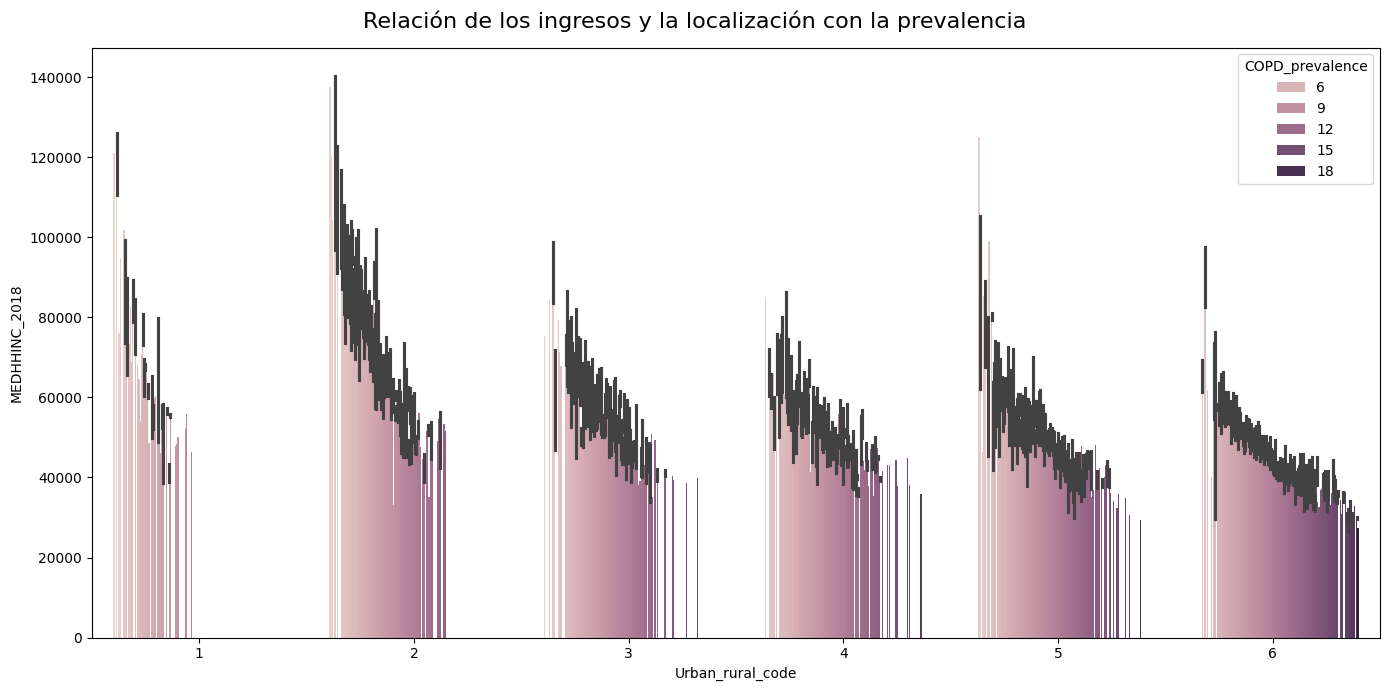

In [18]:
fig, axis = plt.subplots(figsize = (14, 7))
fig.suptitle("Relación de los ingresos y la localización con la prevalencia", fontsize=16)

sns.barplot(data = df_num, x = "Urban_rural_code", y = "MEDHHINC_2018", hue = "COPD_prevalence")

plt.tight_layout()
plt.show()

Se observa lo siguiente:

- Hay una notable variabilidad en la prevalencia de EPOC dentro de cada categoría de urbanización, pero la tendencia general es que las áreas con **menor ingreso** presentan una mayor prevalencia de EPOC.
- Esta tendencia puede estar vinculada a factores socioeconómicos, como el acceso limitado a servicios de salud, mayor exposición a contaminantes rurales (e.g., polvo agrícola), o mayores tasas de tabaquismo en comunidades con menor ingreso.
- Áreas rurales muestran tanto **menores ingresos** como mayor prevalencia de EPOC, lo que podría sugerir que **factores como el acceso limitado a atención médica y condiciones socioeconómicas más desfavorables** están influyendo en los resultados.
- En áreas urbanas, a pesar de los **altos ingresos**, la prevalencia de EPOC es relativamente baja, lo que puede indicar un **mejor acceso a servicios de salud**, mayor conciencia sobre los factores de riesgo, o mejor calidad del aire en ciertas zonas urbanas.

# 4.1 Encoding Categorical Values and Saving JSON files

In [19]:
cn = list(total_data['COUNTY_NAME'].unique())
COUNTY_NAME_encoded = dict(zip(cn, list(range(len(cn)))))

with open('../data/interim/COUNTY_NAME_encoded.json', 'w') as f: 
    json.dump(COUNTY_NAME_encoded, f)

In [20]:
sn = list(total_data['STATE_NAME'].unique())
STATE_NAME_encoded = dict(zip(sn, list(range(len(sn)))))

with open('../data/interim/STATE_NAME_encoded.json', 'w') as f:
    json.dump(STATE_NAME_encoded, f)

In [21]:
#Hacemos una copia del data frame con outliers
df_enc = total_data.copy()

In [22]:
df_enc['COUNTY_NAME_encoded'] = df_enc['COUNTY_NAME'].map(COUNTY_NAME_encoded)
df_enc['STATE_NAME_encoded'] = df_enc['STATE_NAME'].map(STATE_NAME_encoded)

df_enc.drop(columns=['COUNTY_NAME', 'STATE_NAME'], inplace=True)
df_enc.head(3)

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,...,Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code,COUNTY_NAME_encoded,STATE_NAME_encoded
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,13.636445,7738,13.917016,5826,10.478229,4050,7.284042,2014,3.622237,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,158,455,11.8,9.6,2.2,0.0,0.7,...,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,1,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3,0,0
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,12.539102,29986,13.753658,29932,13.728890,20936,9.602701,9368,4.296814,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,5403,2190,10.5,10.3,0.1,0.5,24.3,...,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,1,3,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4,1,0
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,12.354809,3278,13.174712,3076,12.362847,2244,9.018930,1048,4.212049,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,0.184880,307,1.233873,24881,-277,2820,10.4,12.9,-2.5,0.5,-9.1,...,12.914231,2.723340,0.514126,11.631462,9.508784,32.283033,5,26201,6150,23.5,1,5,19689,57.5,55.6,59.1,11325,40.7,39.5,41.9,8013,11.0,10.1,11.8,2159,12.1,10.7,13.3,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6,2,0


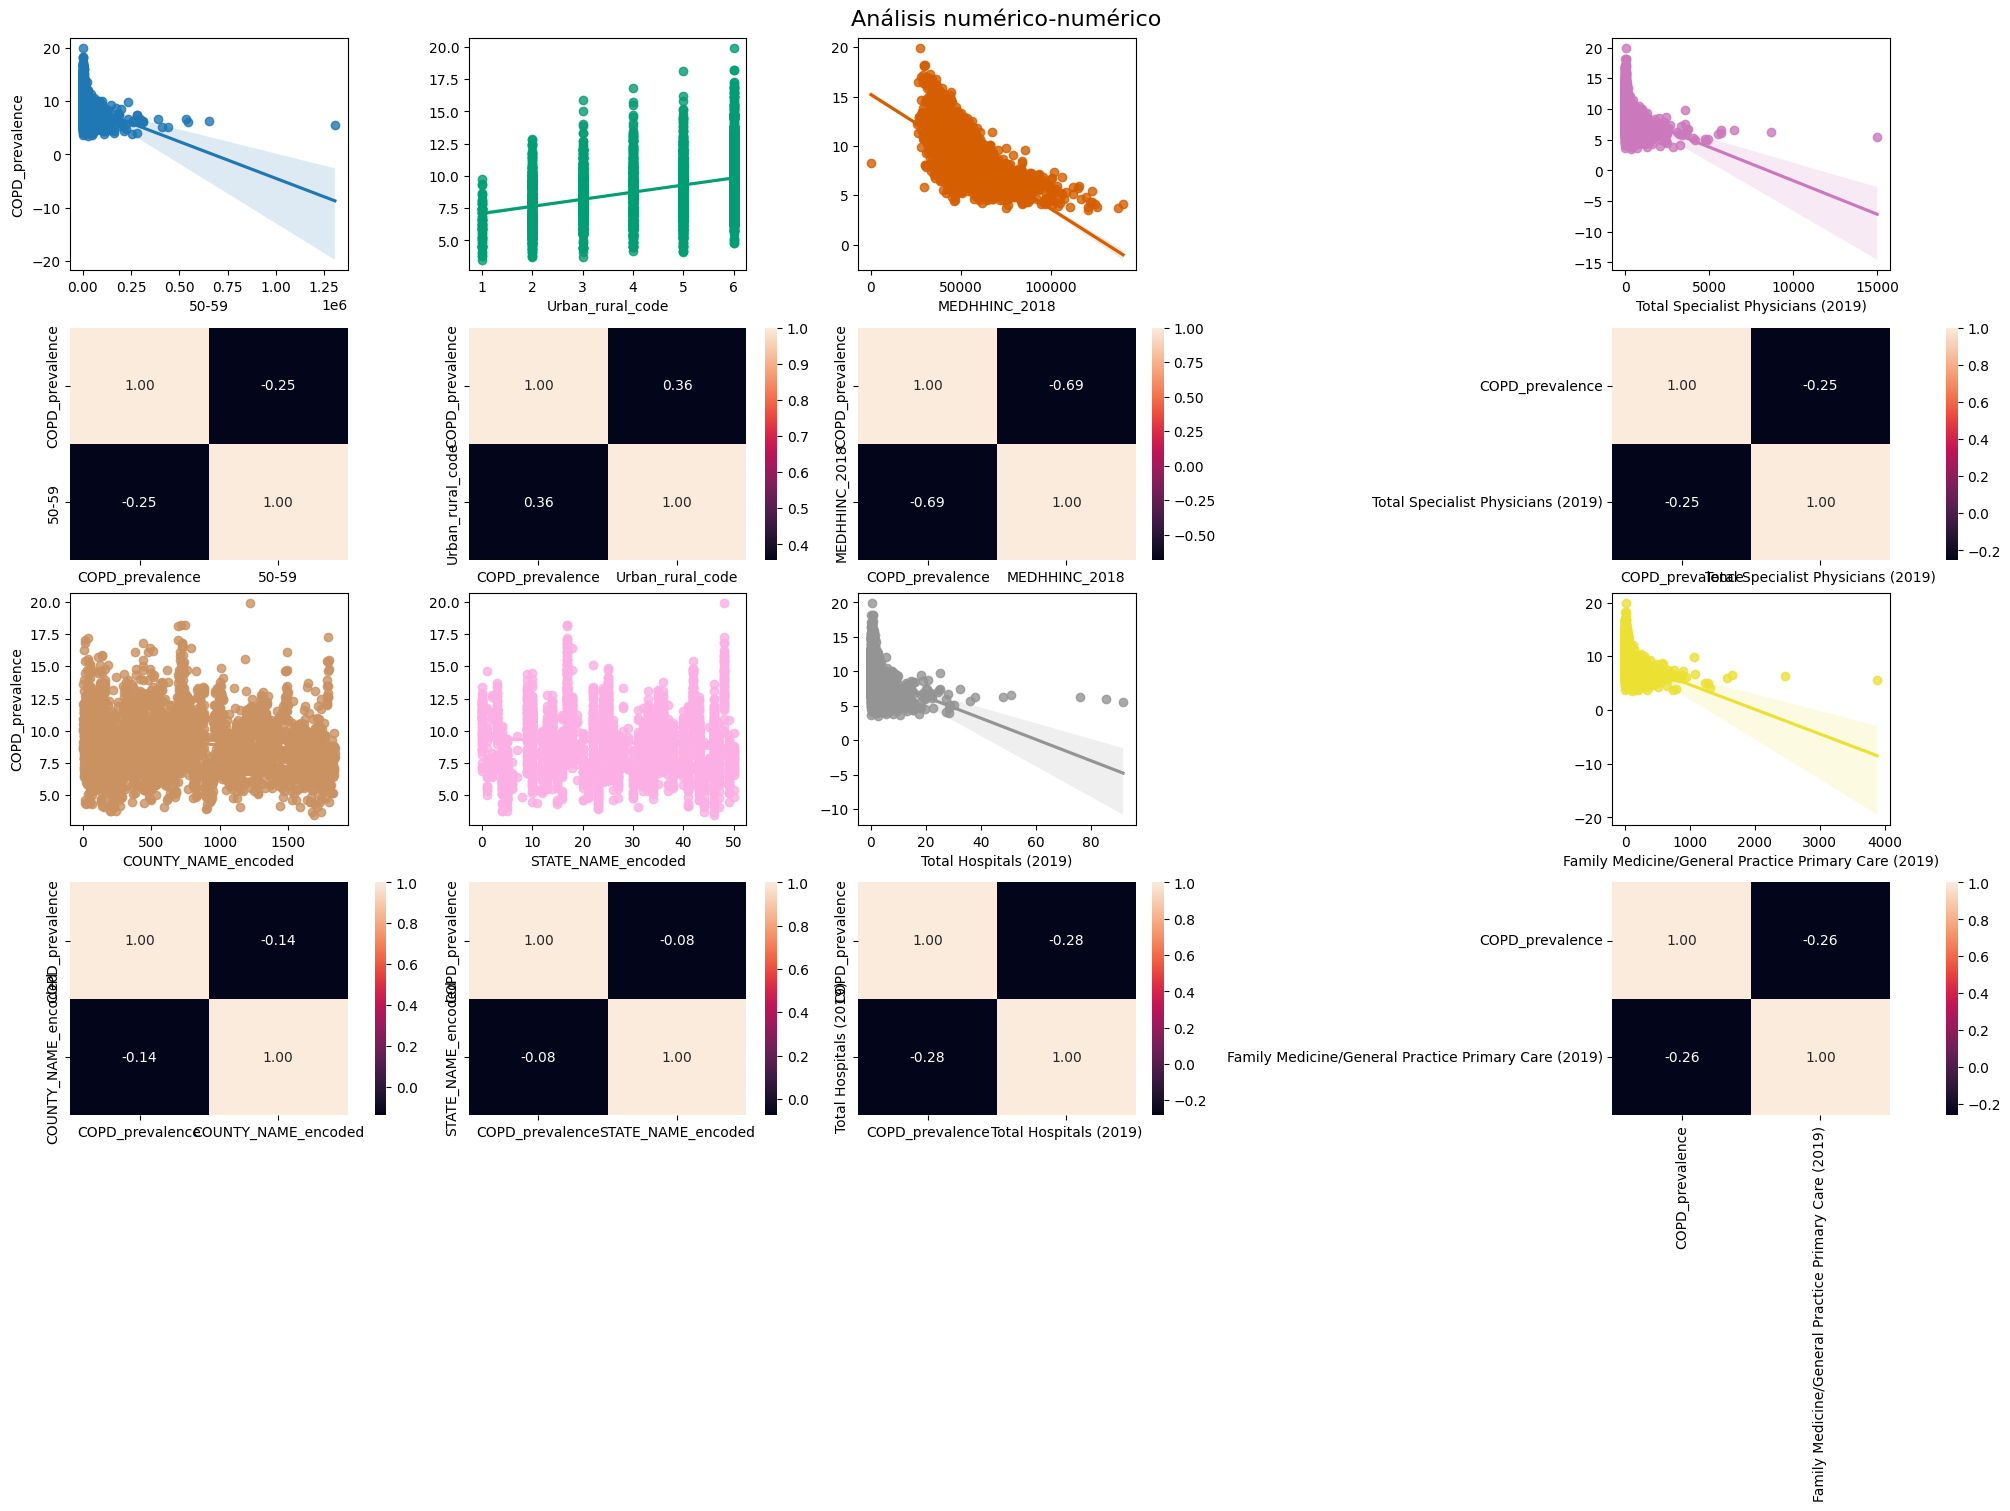

In [23]:
#Analisis de varias variables pt.2
fig, axis = plt.subplots(4, 4, figsize = (20, 15), constrained_layout=True)
fig.suptitle("Análisis numérico-numérico", fontsize=16)


sns.regplot(ax = axis[0, 0], data = df_enc, x = "50-59", y = "COPD_prevalence")
sns.heatmap(df_enc[["COPD_prevalence", "50-59"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(ax = axis[0, 1], data = df_enc, x = "Urban_rural_code", y = "COPD_prevalence", color=sns.color_palette("colorblind")[2]).set(ylabel = None)
sns.heatmap(df_enc[["COPD_prevalence", "Urban_rural_code"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[0, 2], data = df_enc, x = "MEDHHINC_2018", y = "COPD_prevalence", color=sns.color_palette("colorblind")[3]).set(ylabel = None)
sns.heatmap(df_enc[["COPD_prevalence", "MEDHHINC_2018"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 2]).set(ylabel = None)

sns.regplot(ax = axis[0, 3], data = df_enc, x = "Total Specialist Physicians (2019)", y = "COPD_prevalence", color=sns.color_palette("colorblind")[4]).set(ylabel = None)
sns.heatmap(df_enc[["COPD_prevalence", "Total Specialist Physicians (2019)"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 3]).set(ylabel = None)

sns.regplot(ax = axis[2, 0], data = df_enc, x = "COUNTY_NAME_encoded", y = "COPD_prevalence", color=sns.color_palette("colorblind")[5])
sns.heatmap(df_enc[["COPD_prevalence", "COUNTY_NAME_encoded"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0])

sns.regplot(ax = axis[2, 1], data = df_enc, x = "STATE_NAME_encoded", y = "COPD_prevalence", color=sns.color_palette("colorblind")[6]).set(ylabel = None)
sns.heatmap(df_enc[["COPD_prevalence", "STATE_NAME_encoded"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1]).set(ylabel = None)

sns.regplot(ax = axis[2, 2], data = df_enc, x = "Total Hospitals (2019)", y = "COPD_prevalence", color=sns.color_palette("colorblind")[7]).set(ylabel = None)
sns.heatmap(df_enc[["COPD_prevalence", "Total Hospitals (2019)"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 2]).set(ylabel = None)

sns.regplot(ax = axis[2, 3], data = df_enc, x = "Family Medicine/General Practice Primary Care (2019)", y = "COPD_prevalence", color=sns.color_palette("colorblind")[8]).set(ylabel = None)
sns.heatmap(df_enc[["COPD_prevalence", "Family Medicine/General Practice Primary Care (2019)"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 3]).set(ylabel = None)


plt.show()

# 5. Feature Engineering
# 5.1 Outlier Analysis

In [24]:
#Análisis de outliers
df_enc.describe().round(2)

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,...,Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code,COUNTY_NAME_encoded,STATE_NAME_encoded
count,3140.00,3140.00,3140.0,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,...,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00
mean,30401.64,104189.41,12740.3,11.87,13367.98,12.69,14469.33,12.28,13916.49,11.75,12885.21,11.56,13638.03,13.53,11916.21,13.18,7220.31,8.40,4035.54,4.73,79659.79,84.49,13950.26,9.34,1320.23,2.34,6155.62,1.55,254.56,0.14,2848.95,2.12,104189.41,643.42,2576.34,11.17,10.37,0.80,1.11,0.00,...,52.70,28.22,1.66,62.90,44.39,167.33,23.82,102226.63,21322.98,24.74,30.30,103.55,80814.60,46.79,44.66,48.84,33385.40,35.02,33.41,36.59,25276.13,8.61,7.81,9.45,5597.59,9.10,7.84,10.44,5827.24,13.07,12.09,14.05,9326.58,3.45,3.21,3.71,2466.23,4.64,688.48,26.25
std,15150.56,333583.40,41807.3,2.12,42284.39,1.82,49577.73,3.13,48990.95,1.70,43472.19,1.37,42720.63,1.48,34518.58,2.53,20287.50,2.21,12063.78,1.54,237288.05,16.35,58997.87,14.48,5362.40,7.72,43887.98,2.86,2192.08,0.97,11083.92,1.54,333583.40,3134.86,6709.18,2.52,2.69,4.06,2.17,11.45,...,153.88,86.41,4.29,214.74,133.35,543.04,84.60,328387.85,61405.88,5.56,15.13,107.69,258518.99,6.38,6.37,6.38,98886.69,4.52,4.46,4.58,74466.84,1.76,1.61,1.92,15615.29,2.34,2.09,2.61,15720.55,2.72,2.62,2.82,29754.60,0.57,0.53,0.61,7730.42,1.51,541.77,14.26
min,1001.00,88.00,0.0,0.00,0.00,0.00,0.00,0.00,11.00,6.09,4.00,2.63,14.00,5.32,20.00,3.44,6.00,2.20,0.00,0.00,24.00,3.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,88.00,-24009.00,0.00,0.00,0.00,-14.40,-3.90,-62.30,...,0.03,0.01,0.00,0.05,0.03,0.11,0.00,74.00,27.00,5.80,1.00,1.00,88.00,22.00,20.60,23.50,41.00,15.20,14.30,16.20,25.00,3.50,3.30,3.70,7.00,3.50,2.90,4.20,7.00,6.10,5.50,6.70,11.00,1.80,1.70,1.90,3.00,1.00,0.00,0.00
25%,18180.50,10963.25,1280.5,10.59,1374.50,11.67,1263.75,10.50,1232.75,10.69,1245.25,10.69,1483.00,12.74,1476.50,11.62,950.75,7.03,533.00,3.74,9008.75,79.62,142.00,0.87,73.00,0.38,57.00,0.47,5.00,0.03,180.00,1.36,10963.25,-78.00,174.75,9.70,8.70,-1.80,0.00,-6.20,...,5.44,2

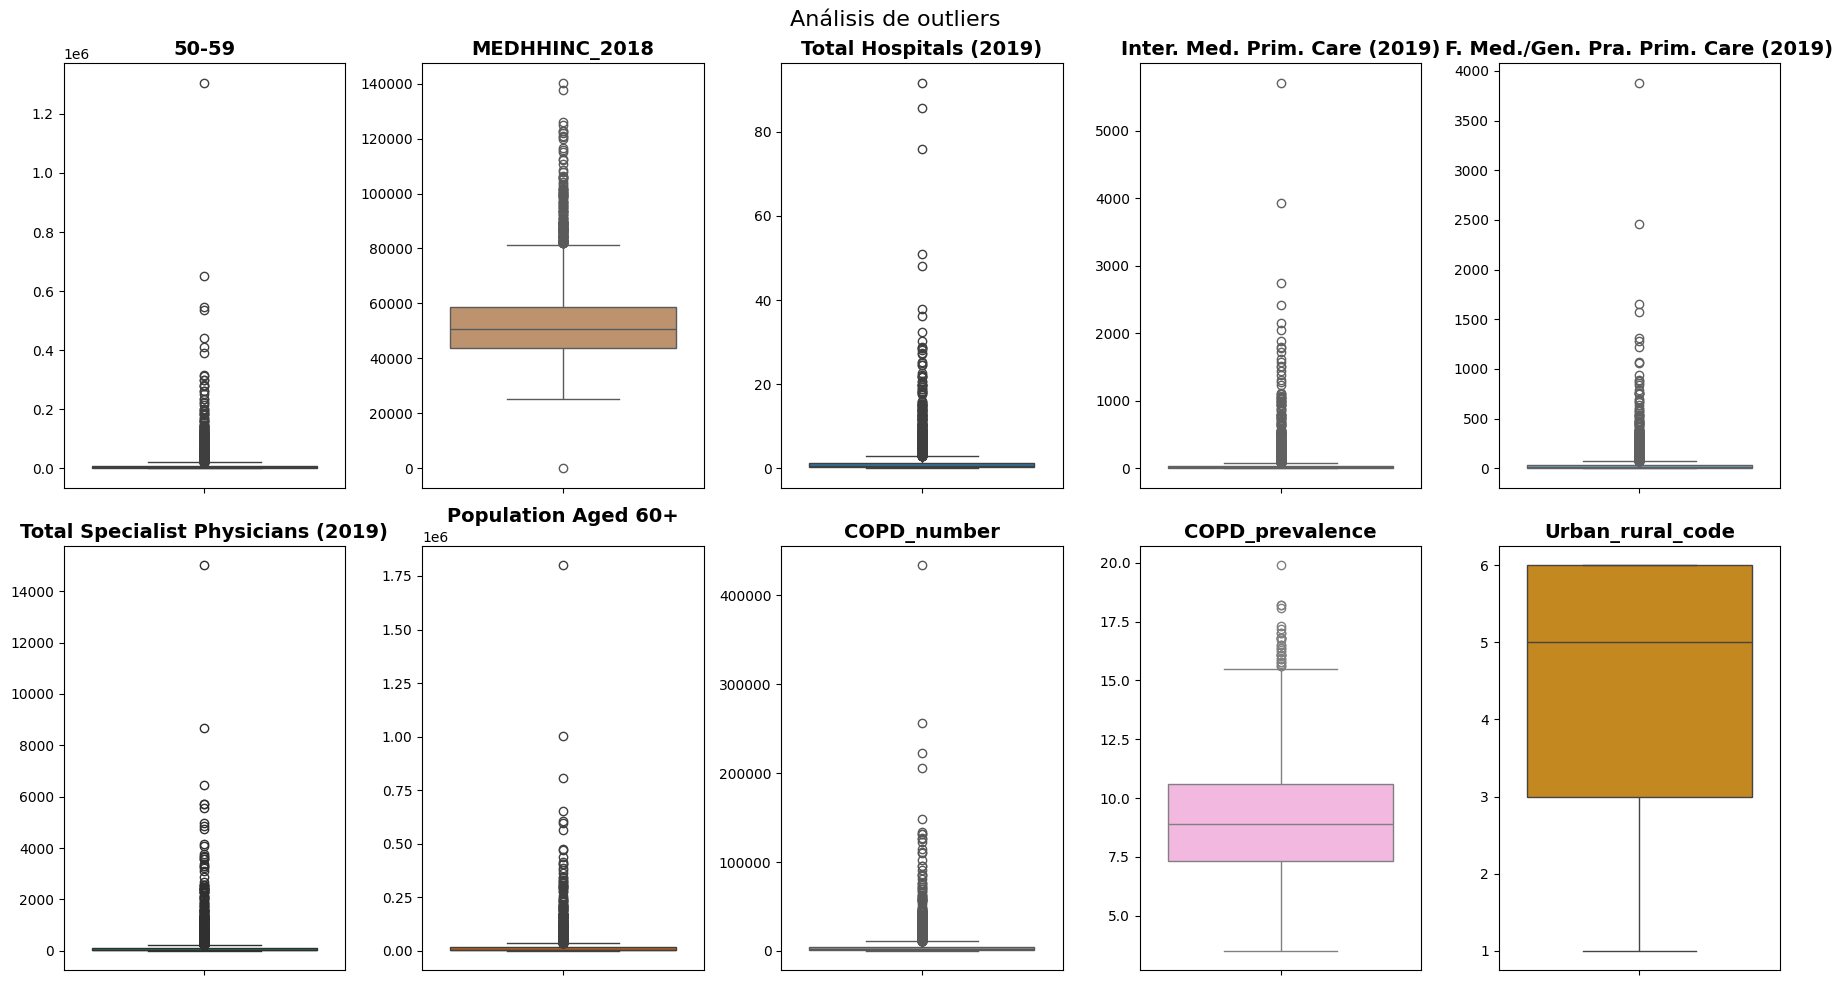

In [25]:
fig, axes = plt.subplots(2, 5, figsize = (18, 10))
fig.suptitle("Análisis de outliers", fontsize=16)

sns.boxplot(ax = axes[0, 0], data = df_enc, y = "50-59").set_title("50-59", fontsize=14, fontweight='bold')
sns.boxplot(ax = axes[0, 1], data = df_enc, y = "MEDHHINC_2018", color=sns.color_palette("colorblind")[5]).set_title("MEDHHINC_2018", fontsize=14, fontweight='bold')
sns.boxplot(ax = axes[0, 2], data = df_enc, y = "Total Hospitals (2019)").set_title("Total Hospitals (2019)", fontsize=14, fontweight='bold')
sns.boxplot(ax = axes[0, 3], data = df_enc, y = "Internal Medicine Primary Care (2019)", color=sns.color_palette("colorblind")[4]).set_title("Inter. Med. Prim. Care (2019)", fontsize=14, fontweight='bold')
sns.boxplot(ax = axes[0, 4], data = df_enc, y = "Family Medicine/General Practice Primary Care (2019)", color=sns.color_palette("colorblind")[9]).set_title("F. Med./Gen. Pra. Prim. Care (2019)", fontsize=14, fontweight='bold')
sns.boxplot(ax = axes[1, 0], data = df_enc, y = "Total Specialist Physicians (2019)", color=sns.color_palette("colorblind")[2]).set_title("Total Specialist Physicians (2019)", fontsize=14, fontweight='bold')
sns.boxplot(ax = axes[1, 1], data = df_enc, y = "Population Aged 60+", color=sns.color_palette("colorblind")[3]).set_title("Population Aged 60+", fontsize=14, fontweight='bold')
sns.boxplot(ax = axes[1, 2], data = df_enc, y = "COPD_number", color=sns.color_palette("colorblind")[7]).set_title("COPD_number", fontsize=14, fontweight='bold')
sns.boxplot(ax = axes[1, 3], data = df_enc, y = "COPD_prevalence", color=sns.color_palette("colorblind")[6]).set_title("COPD_prevalence", fontsize=14, fontweight='bold')
sns.boxplot(ax = axes[1, 4], data = df_enc, y = "Urban_rural_code", color=sns.color_palette("colorblind")[1]).set_title("Urban_rural_code", fontsize=14, fontweight='bold')

for ax in axes.flatten():
    if ax: 
        ax.set(ylabel=None)

plt.tight_layout()
plt.show()

In [26]:
#Creamos una copia sin outliers
df_enc_no = df_enc.copy()

In [27]:
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'../data/interim/outliers_lims_{feature_name}.json'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'w') as f:
        json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, f)

    return x

In [28]:
df_enc_no['50-59'] = remove_outliers(df_enc_no['50-59'], '50-59')
df_enc_no['MEDHHINC_2018'] = remove_outliers(df_enc_no['MEDHHINC_2018'], 'MEDHHINC_2018')
df_enc_no['Total Hospitals (2019)'] = remove_outliers(df_enc_no['Total Hospitals (2019)'], 'Total Hospitals (2019)')
df_enc_no['Internal Medicine Primary Care (2019)'] = remove_outliers(df_enc_no['Internal Medicine Primary Care (2019)'], 'Internal Medicine Primary Care (2019)')
df_enc_no['Total Specialist Physicians (2019)'] = remove_outliers(df_enc_no['Total Specialist Physicians (2019)'], 'Total Specialist Physicians (2019)')
df_enc_no['Population Aged 60+'] = remove_outliers(df_enc_no['Population Aged 60+'], 'Population Aged 60+')
df_enc_no['COPD_number'] = remove_outliers(df_enc_no['COPD_number'], 'COPD_number')
df_enc_no['COPD_prevalence'] = remove_outliers(df_enc_no['COPD_prevalence'], 'COPD_prevalence')
df_enc_no['Family Medicine/General Practice Primary Care (2019)'] = remove_outliers(df_enc_no['Family Medicine/General Practice Primary Care (2019)'], 'Family Medicine/General Practice Primary Care (2019)')

# 5.2 Missing Values

In [29]:
df_enc.isna().sum()

fips                      0
TOT_POP                   0
0-9                       0
0-9 y/o % of total pop    0
19-Oct                    0
                         ..
CKD_Upper 95% CI          0
CKD_number                0
Urban_rural_code          0
COUNTY_NAME_encoded       0
STATE_NAME_encoded        0
Length: 108, dtype: int64

# 5.3 Split train/test of both Data Frames

In [30]:
def split(target, df, test_size=0.2, random_state=123):
    X = df.drop(columns=target)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [31]:
#Dividimos el data frame original
X_train_with_outliers, X_test_with_outliers, y_train, y_test = split('COPD_prevalence', df_enc)
X_train_without_outliers, X_test_without_outliers, _, _ = split('COPD_prevalence', df_enc_no)

y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

# 5.4 Normalization

In [32]:
def norm(X_train, X_test, reference: str):
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_norm = scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)

    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    dump(scaler, open(f'../data/interim/_{reference}.sav', 'wb'))

    return X_train_norm, X_test_norm

In [33]:
X_train_with_outliers_norm, X_test_with_outliers_norm = norm(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_norm, X_test_without_outliers_norm = norm(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

# 5.5 Min-Max Scaling

In [34]:
def minmax(X_train, X_test, reference: str):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index = X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index = X_test.index, columns=X_test.columns)
    
    dump(scaler, open(f'../data/interim/minmax_{reference}.sav', 'wb'))

    return X_train_minmax, X_test_minmax

In [35]:
X_train_with_outliers_minmax, X_test_with_outliers_minmax = minmax(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_minmax, X_test_without_outliers_minmax = minmax(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

# 6. Feature Selection

In [36]:
def kselection(X_train, X_test, y_train, k, reference: str):
    selection_model = SelectKBest(f_classif, k=k)
    selection_model.fit(X_train, y_train)
    cols = selection_model.get_support()

    X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[cols]) 
    X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns.values[cols])

    dump(selection_model, open(f'../data/interim/selection_model_{reference}.sav', 'wb'))

    return X_train_sel, X_test_sel  

In [37]:
X_train_with_outliers_sel, X_test_with_outliers_sel = kselection(X_train_with_outliers, X_test_with_outliers, y_train, 34, 'with_outliers')
X_train_without_outliers_sel, X_test_without_outliers_sel = kselection(X_train_without_outliers, X_test_without_outliers, y_train, 34, 'without_outliers')

# 6.1 Applying the filter to the normalized and minmax scaled data frames

In [38]:
X_train_with_outliers_norm_sel = X_train_with_outliers_norm[X_train_with_outliers_sel.columns]
X_train_without_outliers_norm_sel = X_train_without_outliers_norm[X_train_with_outliers_sel.columns]

X_test_with_outliers_norm_sel = X_test_with_outliers_norm[X_test_with_outliers_sel.columns]
X_test_without_outliers_norm_sel = X_test_without_outliers_norm[X_test_with_outliers_sel.columns]

X_train_with_outliers_minmax_sel = X_train_with_outliers_minmax[X_train_with_outliers_sel.columns]
X_train_without_outliers_minmax_sel = X_train_without_outliers_minmax[X_train_without_outliers_sel.columns]

X_test_with_outliers_minmax_sel = X_test_with_outliers_minmax[X_test_with_outliers_sel.columns]
X_test_without_outliers_minmax_sel = X_test_without_outliers_minmax[X_test_without_outliers_sel.columns]

# 6.2 Saving the CSV files

In [39]:
dfs_train = [X_train_with_outliers_sel, X_train_without_outliers_sel, 
             X_train_with_outliers_norm_sel, X_train_without_outliers_norm_sel, 
             X_train_with_outliers_minmax_sel, X_train_without_outliers_minmax_sel]

dfs_test = [X_test_with_outliers_sel, X_test_without_outliers_sel, 
            X_test_with_outliers_norm_sel, X_test_without_outliers_norm_sel, 
            X_test_with_outliers_minmax_sel, X_test_without_outliers_minmax_sel]

In [40]:
# Data frame de entrenamiento
X_train_with_outliers_sel.to_csv('../data/processed/X_train_with_outliers_sel.csv', index=False)
X_train_without_outliers_sel.to_csv('../data/processed/X_train_without_outliers_sel.csv', index=False)
X_train_with_outliers_norm_sel.to_csv('../data/processed/X_train_with_outliers_norm_sel.csv', index=False)
X_train_without_outliers_norm_sel.to_csv('../data/processed/X_train_without_outliers_norm_sel.csv', index=False)
X_train_with_outliers_minmax_sel.to_csv('../data/processed/X_train_with_outliers_minmax_sel.csv', index=False)
X_train_without_outliers_minmax_sel.to_csv('../data/processed/X_train_without_outliers_minmax_sel.csv', index=False)

# Data frame de prueba
X_test_with_outliers_sel.to_csv('../data/processed/X_test_with_outliers_sel.csv', index=False)
X_test_without_outliers_sel.to_csv('../data/processed/X_test_without_outliers_sel.csv', index=False)
X_test_with_outliers_norm_sel.to_csv('../data/processed/X_test_with_outliers_norm_sel.csv', index=False)
X_test_without_outliers_norm_sel.to_csv('../data/processed/X_test_without_outliers_norm_sel.csv', index=False)
X_test_with_outliers_minmax_sel.to_csv('../data/processed/X_test_with_outliers_minmax_sel.csv', index=False)
X_test_without_outliers_minmax_sel.to_csv('../data/processed/X_test_without_outliers_minmax_sel.csv', index=False)

# Machine Learning
# Logistic Regression Model

In [41]:
# Train data frames
X_train_with_outliers_sel = pd.read_csv('../data/processed/X_train_with_outliers_sel.csv')
X_train_without_outliers_sel = pd.read_csv('../data/processed/X_train_without_outliers_sel.csv')
X_train_with_outliers_norm_sel = pd.read_csv('../data/processed/X_train_with_outliers_norm_sel.csv')
X_train_without_outliers_norm_sel = pd.read_csv('../data/processed/X_train_without_outliers_norm_sel.csv')
X_train_with_outliers_minmax_sel = pd.read_csv('../data/processed/X_train_with_outliers_minmax_sel.csv')
X_train_without_outliers_minmax_sel = pd.read_csv('../data/processed/X_train_without_outliers_minmax_sel.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')

# Test data frames
X_test_with_outliers_sel = pd.read_csv('../data/processed/X_test_with_outliers_sel.csv')
X_test_without_outliers_sel = pd.read_csv('../data/processed/X_test_without_outliers_sel.csv')
X_test_with_outliers_norm_sel = pd.read_csv('../data/processed/X_test_with_outliers_norm_sel.csv')
X_test_without_outliers_norm_sel = pd.read_csv('../data/processed/X_test_without_outliers_norm_sel.csv')
X_test_with_outliers_minmax_sel = pd.read_csv('../data/processed/X_test_with_outliers_minmax_sel.csv')
X_test_without_outliers_minmax_sel = pd.read_csv('../data/processed/X_test_without_outliers_minmax_sel.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [42]:
train_dfs = [
  X_train_with_outliers_sel,
  X_train_without_outliers_sel,
  X_train_with_outliers_norm_sel,
  X_train_without_outliers_norm_sel,
  X_train_with_outliers_minmax_sel,
  X_train_without_outliers_minmax_sel
]
test_dfs = [
  X_test_with_outliers_sel,
  X_test_without_outliers_sel,
  X_test_with_outliers_norm_sel,
  X_test_without_outliers_norm_sel,
  X_test_with_outliers_minmax_sel,
  X_test_without_outliers_minmax_sel
]

results = []
models = []

for df_index in range(len(train_dfs)):
  model = LinearRegression()
  train_df = train_dfs[df_index]
  model.fit(train_df, y_train)
  y_train_pred = model.predict(train_df)
  y_test_pred = model.predict(test_dfs[df_index])

  results.append(
        {
            "index": df_index,
            "train_mse": root_mean_squared_error(y_train, y_train_pred),
            "test_mse": root_mean_squared_error(y_test, y_test_pred),
            "train_r2": r2_score(y_train, y_train_pred),
            "test_r2": r2_score(y_test, y_test_pred)
        }
    )
  models.append(model)
sorted(results, key=lambda x: x["train_mse"])

[{'index': 1,
  'train_mse': np.float64(0.048347397543916266),
  'test_mse': np.float64(0.05077990970568341),
  'train_r2': 0.999574826297207,
  'test_r2': 0.9995307046457892},
 {'index': 3,
  'train_mse': np.float64(0.048347397543916294),
  'test_mse': np.float64(0.05077990970569376),
  'train_r2': 0.999574826297207,
  'test_r2': 0.999530704645789},
 {'index': 5,
  'train_mse': np.float64(0.0483473975439163),
  'test_mse': np.float64(0.05077990970569327),
  'train_r2': 0.999574826297207,
  'test_r2': 0.999530704645789},
 {'index': 0,
  'train_mse': np.float64(0.04837706092895981),
  'test_mse': np.float64(0.05078680916346278),
  'train_r2': 0.9995743044093308,
  'test_r2': 0.9995305771109643},
 {'index': 2,
  'train_mse': np.float64(0.04837706092895982),
  'test_mse': np.float64(0.05078680916345823),
  'train_r2': 0.9995743044093308,
  'test_r2': 0.9995305771109644},
 {'index': 4,
  'train_mse': np.float64(0.04837706092895983),
  'test_mse': np.float64(0.05078680916345838),
  'train_r

In [43]:
print(f"Intercep (a): {models[1].intercept_}")
print(f"Coefficients (b1, b2): {models[1].coef_}")

Intercep (a): [-0.01544891]
Coefficients (b1, b2): [[-8.67143227e-04 -1.83632832e-04  5.52472058e-07  7.85922835e-05
  -3.52926132e-04  1.51426569e-03  2.85475025e-04  5.44741881e-04
  -1.60593711e-04  2.87308665e-03 -2.19355038e-03  7.29710066e-07
  -3.68452126e-08 -9.68868727e-08  5.25763119e-04 -6.68669223e-08
  -2.40929190e-04  6.06314212e-02 -2.57878970e-02 -3.49746773e-02
   2.87795085e-02 -2.02271237e-02 -8.65522246e-03  1.56837509e-01
  -3.77105756e-02 -1.05656938e-01  5.09318653e-01  4.88450412e-01
   1.98645744e-01 -9.83619324e-02 -9.92346744e-02  9.25444088e-02
  -9.40437338e-02 -3.04632906e-02]]


In [44]:
y_pred = model.predict(X_test_without_outliers_sel)
y_pred

array([[1157.92048168],
       [1268.14119534],
       [1003.50321289],
       [2496.71890559],
       [ 800.51049526],
       [1079.08340582],
       [1049.72723068],
       [ 810.629459  ],
       [1030.02208272],
       [ 984.48428223],
       [ 915.87372851],
       [1211.20678466],
       [ 806.86777484],
       [1283.14300689],
       [ 913.30764554],
       [1050.9917684 ],
       [1072.83334204],
       [1245.9786821 ],
       [1080.88782975],
       [ 934.71692655],
       [1114.7582994 ],
       [1118.99742687],
       [ 989.58882021],
       [ 890.68546647],
       [ 770.15903226],
       [1055.54217355],
       [1305.47268458],
       [1033.09889959],
       [ 750.24930549],
       [ 838.88955122],
       [ 855.11297662],
       [ 925.8324373 ],
       [ 914.20250985],
       [1476.77695307],
       [ 955.91408907],
       [1125.57475681],
       [ 824.88385343],
       [1216.79616335],
       [1078.71460718],
       [ 989.43876506],
       [ 829.98548582],
       [ 880.116

# Model Optimization

In [45]:
alpha = 1.0
lasso_model = Lasso(alpha = alpha)

lasso_model.fit(X_train_without_outliers_sel, y_train)

score = lasso_model.score(X_test_without_outliers_sel, y_test)
print("Coefficients:", lasso_model.coef_)
print("R2 score:", score)

Coefficients: [-0.00000000e+00 -0.00000000e+00 -2.33735586e-06  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  1.80316839e-02 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.61042842e-05
  1.72286687e-05 -8.99884275e-06  0.00000000e+00 -0.00000000e+00
  4.49157479e-03  0.00000000e+00  0.00000000e+00  4.04540350e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.00942201e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
R2 score: 0.9453949754028215


In [46]:
alpha = 1.0
ridge_model = Ridge(alpha = alpha)

ridge_model.fit(X_train_without_outliers_sel, y_train)

score = ridge_model.score(X_test_without_outliers_sel, y_test)
print("Coefficients:", ridge_model.coef_)
print("R2 score:", score)

Coefficients: [[-8.12843473e-04 -1.10189617e-04  5.50320854e-07  5.01189569e-05
  -3.36860068e-04  1.51449257e-03  3.59155767e-04  4.96715218e-04
  -5.40861586e-05  2.74347061e-03 -2.10758617e-03  7.16903988e-07
  -2.46783977e-08 -8.82760909e-08  6.65212362e-04 -9.36952401e-08
  -2.33566794e-04  5.99271601e-02 -2.53435385e-02 -3.46872303e-02
   2.39974284e-02 -1.81234758e-02 -5.95023319e-03  1.23785754e-01
  -2.21923245e-02 -8.81994657e-02  5.03976770e-01  4.92269552e-01
   1.57632659e-01 -7.53384401e-02 -8.07234042e-02  6.14782346e-02
  -6.68356886e-02 -2.57276892e-02]]
R2 score: 0.9995300216209815


In [47]:
alpha = 1.0
elasticnet_model = ElasticNet(alpha = alpha)

elasticnet_model.fit(X_train_without_outliers_sel, y_train)

score = elasticnet_model.score(X_test_without_outliers_sel, y_test)
print("Coefficients:", elasticnet_model.coef_)
print("R2 score:", score)

Coefficients: [-0.00000000e+00 -0.00000000e+00 -5.23330226e-07  0.00000000e+00
 -7.32252783e-03  1.77631114e-03  1.96741532e-02 -0.00000000e+00
  0.00000000e+00  2.89347642e-04  0.00000000e+00 -4.16045543e-05
  1.54661540e-05 -1.08499497e-05  0.00000000e+00  2.74174525e-06
  4.88486212e-03  1.87678110e-02  0.00000000e+00  2.67558070e-02
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.16382287e-01  4.71101615e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
R2 score: 0.9667571018752765


/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.855e+02, tolerance: 1.381e+00
  model = cd_fast.enet_coordinate_descent(


In [48]:
dump(ridge_model, open("../models/ridge_alpha-1.0.sav", "wb"))